In [1]:
import numpy as np
import pandas as pd
import datetime
import time
from demand_model import *
import pywt
from utils import *
from uncertainty_process import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## create DemandFile object, get basic date from it, date, date_ud, cusid, cusid_ud, and dataframe
Demandbase = DemandFile('SelectedDataFor1EE.xlsx', 'Sheet1')
Date = Demandbase.getDate()
Date_ud = Demandbase.getDate_ud()
CusID = Demandbase.getCusID()
CusID_ud = Demandbase.getCusID_ud()

In [2]:
def inlist(dm,CLT):
    idbase = (dm['CustomerID'] == 0)
    for ind in CLT:
        tmpid = (dm['CustomerID'] == ind)
        idbase = idbase | tmpid
    return idbase
def rateCal(mlist):
    ori = np.mean(mlist[:-1])
    new = mlist[-1]
    rate = (ori - new)/ori
    return rate

In [3]:
file_lp_all = './result/load_profiles_all.csv'
file_lp_allcus_allyear = './result/load_profiles_allcus_allyear.csv'
file_lp_mean_allyear = './result/load_profiles_mean_allyear.csv'
file_lp_sum_allyear = './result/load_profiles_sum_allyear.csv'
file_lp_daily_sum = './result/load_profiles_sum_daily.csv'
file_lp_daily_mean = './result/load_profiles_mean_daily.csv'

In [4]:
import random
## setting data use parameters, set customers and dates which is taken into consideration
modset_c = ['fixed','period','list']
modset_d = ['fixed','period','list']
Cus = 1002
CusStart = 1002
CusEnd = 2000
Date = '2009-07-14' # this is a Monday
DateStart = '2009-09-04' ## including
DateEnd = '2010-04-17' ## not including, start from friday, then end on friday
DateList = ['2009-07-14', '2009-07-19']

In [5]:
# all load profiles
DCL = 3 # decomposition level
## setting mode and get considering data
mod_c = 'list'
mod_d = 'period'
agmod = 'sum'
## initiate database
Demand = Demandbase.getDataframeAll()
indlist = random.sample(range(0,929), 200)
indlist = np.sort(indlist)
CusList = []
for i_ind in indlist:
    CusList.append(CusID_ud[i_ind])
# get data which comply with customer id conditions first, use switch code
for case in switch(mod_c):
    if case('fixed'):
        Demand = Demand[(Demand['CustomerID'] == Cus)]
        break
    if case('period'):
        Demand = Demand[(Demand['CustomerID'] >= CusStart) & (Demand['CustomerID'] < CusEnd)]
        break
    if case('list'):
        ils = inlist(Demand, CusList)
        Demand = Demand[inlist(Demand, CusList)]
        break
    if case():
        print "mod_c setting error #1"

# get data which comply with date condition, then left only data comply with both cusid and date
for case in switch(mod_d):
    if case('fixed'):
        Demand = Demand[(Demand['Date'] == Date)]
        break
    if case('period'):
        Demand = Demand[(Demand['Date'] >= DateStart) & (Demand['Date'] < DateEnd)]
        break
    if case('list'):
        Demand = Demand[(Demand['Date'] in DateList)]
        break
    if case():# default, could also just omit condition or 'if True'
        print "mod_d setting error #2"
        # No need to break here, it'll stop anyway
Demand0 = Demand[(Demand['CustomerID'] == CusStart)]
Demand0['CustomerID'] = 1000
db = np.array(Demand)[:,2:] ## selected N customers load profiles
#print db.shape
cuscount = len(indlist)
#print cuscount
db1 = db.reshape((cuscount, -1))
db2_mean = np.mean(db1, axis = 0)
db2_sum = np.sum(db1, axis = 0)
db3_mean = db2_mean.reshape((-1, 48))
db3_sum = db2_sum.reshape((-1,48))
if agmod == 'mean':
    db3 = db2_mean.reshape((-1, 48))
else: 
    db3 = db2_sum.reshape((-1,48))    
aggregated_load = db3
days = db3.shape[0]
#print days

In [6]:
print 'Uncertainty calculation'
## uc modelling step 1, decomposition
umlist = []
for cusind in indlist:
    cus = CusID_ud[cusind]
    inputframe = Demand[(Demand['CustomerID'] == cus)]
    inputs = np.array(inputframe)[:,2:]
    umtmp = uc_process(inputs, DCL)
    umlist.append(UncertaintyModel(Cus,umtmp))
print 'umlist size: ' + str(len(umlist))
uclist = uc_process(aggregated_load, DCL)
umlist.append(UncertaintyModel(1000, uclist))
def uc_analysis(UMList):
    meanlist1 = []
    meanlist2 = []
    meanlist3 = []
    datelist1 = []
    datelist2 = []
    datelist3 = []
    tpntlist1 = []
    tpntlist2 = []
    tpntlist3 = []
    ucmlist = []
    ucdlist = []
    uctlist = []
    count = len(UMList)
    for ind in range(count):
        lv = UMList[ind].getlv()
        if lv == 3:
            (mean1, mean2, mean3, date1, date2, date3, tpnt1, tpnt2, tpnt3, ucm, ucd, uct) = UMList[ind].getuc()
            meanlist1.append(mean1)
            meanlist2.append(mean2)
            meanlist3.append(mean3)
            datelist1.append(date1)
            datelist2.append(date2)
            datelist3.append(date3)
            tpntlist1.append(tpnt1)
            tpntlist2.append(tpnt2)
            tpntlist3.append(tpnt3)
            ucmlist.append(ucm)
            ucdlist.append(ucd)
            uctlist.append(uct)
    return (meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist)

(meanlist1,meanlist2,meanlist3,datelist1,datelist2,datelist3,tpntlist1,tpntlist2,tpntlist3, ucmlist, ucdlist, uctlist) = uc_analysis(umlist)
#meanlist1 # for 5 cus, 4 days, only 5 values for each cus, draw line chart in single figure
#datelist1 # for 5 cus, 4 days, 5 X 4 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along customers, to find uc in different dates
#tpntlist1 # for 5 cus, 4 days, 5 X 48 matrix, draw 2d surface figure to show, and 3 level in single figure, and also average along custoemrs, to find uc in different time points
red_h = (rateCal(meanlist1))
red_m = (rateCal(meanlist2))
red_l = (rateCal(meanlist3))
reduction_overall = rateCal(ucmlist)
print 'uc_high: ' + str(np.mean(meanlist1))
print 'uc_mid: ' + str(np.mean(meanlist2))
print 'uc_low: ' + str(np.mean(meanlist3))
print 'uc_reduction_high: ' + str(red_h)
print 'uc_reduction_mid: ' + str(red_m)
print 'uc_reduction_low: ' + str(red_l)
print 'uc_reduction_overall: ' + str(reduction_overall)

Uncertainty calculation
umlist size: 200
uc_high: 0.28619614483
uc_mid: 0.307754444854
uc_low: 0.316741886018
uc_reduction_high: -24.4139208252
uc_reduction_mid: -41.5581137155
uc_reduction_low: -59.3980830316
uc_reduction_overall: -43.4039691473


load profiles demonstration
----print all daily LPs and the mean LP


/home/codefisheng/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'serif'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


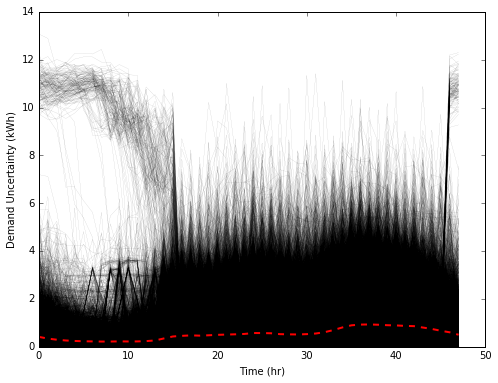

'\n# OUTPUT TO CSV FILES AS DATAFILE\npd.DataFrame(db).to_csv(file_lp_all)\npd.DataFrame(db1).to_csv(file_lp_allcus_allyear)\npd.DataFrame(db2_mean).to_csv(file_lp_mean_allyear)\npd.DataFrame(db2_sum).to_csv(file_lp_sum_allyear)\npd.DataFrame(db3_mean).to_csv(file_lp_daily_mean)\npd.DataFrame(db3_sum).to_csv(file_lp_daily_sum)\n'

In [7]:
print 'load profiles demonstration\n----print all daily LPs and the mean LP'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

x = range(48)
db4 = db1.reshape((-1, 48))
days = db4.shape[0]
for i in range(days):
    plot(range(48), db4[i], color = 'black', ls = 'solid', linewidth = 0.05)
ax.plot(x, np.mean(db4, axis = 0), color='r', ls='dashed', linewidth = 2)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()
fig.savefig('load_profiles.png')
'''
# OUTPUT TO CSV FILES AS DATAFILE
pd.DataFrame(db).to_csv(file_lp_all)
pd.DataFrame(db1).to_csv(file_lp_allcus_allyear)
pd.DataFrame(db2_mean).to_csv(file_lp_mean_allyear)
pd.DataFrame(db2_sum).to_csv(file_lp_sum_allyear)
pd.DataFrame(db3_mean).to_csv(file_lp_daily_mean)
pd.DataFrame(db3_sum).to_csv(file_lp_daily_sum)
'''

In [8]:
def get_raw_uncertainty2(inputs, DCL):
    uc1 = []
    uc2 = []
    uc3 = []
    uc = []
    for ipt in inputs:
        wc = WaveletClass(ipt, 'haar', 'constant', 4)
        wc.decompose()
        (tmp1, tmp2, tmp3) = wc.get_uncertainty(3)
        tmpuc = wc.get_uccomp()
        uc1.append(tmp1)
        uc2.append(tmp2)
        uc3.append(tmp3)
        uc.append(tmpuc)
    uc1 = np.array(uc1)
    uc2 = np.array(uc2)
    uc3 = np.array(uc3)
    uc = np.array(uc)
    return [uc1, uc2, uc3, uc]
oucmat1 = []
oucmat2 = []
oucmat3 = []
oucmat = []
for cusind in indlist:
    cus = CusID_ud[cusind]
    inputframe = Demand[(Demand['CustomerID'] == cus)]
    inputs = np.array(inputframe)[:,2:]
    [tmp1, tmp2, tmp3, tmp] = get_raw_uncertainty2(inputs, DCL)
    oucmat.append(tmp)
    oucmat1.append(tmp1)
    oucmat2.append(tmp2)
    oucmat3.append(tmp3)

In [9]:
ucmat1 = np.array(oucmat1)
print ucmat1.shape
demand = db1.reshape([db1.shape[0], -1, 48])
print demand.shape
ucmat1 = ucmat1.reshape(ucmat1.shape[0], -1, 7, ucmat1.shape[2])
demand = demand.reshape(demand.shape[0], -1, 7, demand.shape[2])
whlist = []
mwlist = []
mhlist = []
for i in range(ucmat1.shape[0]):
    subuc = ucmat1[i]
    uc_wh = np.std(subuc, axis = 0)
    uc_mw = np.std(subuc, axis = 2)
    uc_mh = np.std(subuc, axis = 1)
    whlist.append(uc_wh)
    mwlist.append(uc_mw)
    mhlist.append(uc_mh)
whlist = np.array(whlist)
uc_weeks_hours = np.mean(whlist, axis = 0)
uc_months_weeks = np.mean(mwlist, axis = 0)
uc_months_hours = np.mean(mhlist, axis = 0)

(200, 224, 48)
(200, 224, 48)


Low Freq. Channel  
----print all customers - demand and low freq. channel uncertainty


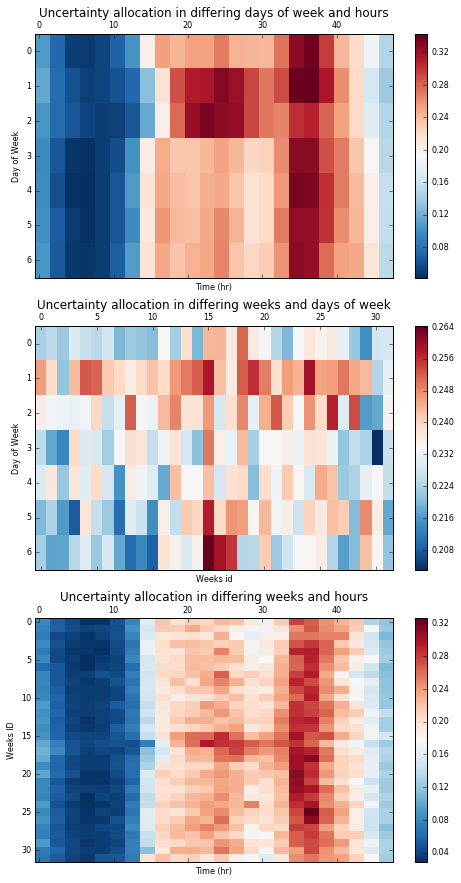

In [10]:
print 'Low Freq. Channel  \n----print all customers - demand and low freq. channel uncertainty'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 24/1.618))
color = cm.RdBu_r
ax = fig.add_subplot(3, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

im1 = ax.matshow(uc_weeks_hours, cmap=color, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im1)
plt.title('Uncertainty allocation in differing days of week and hours')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Day of Week')

ax = fig.add_subplot(3, 1, 2)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

im2 = ax.matshow(uc_months_weeks.T, cmap=color, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im2)
plt.title('Uncertainty allocation in differing weeks and days of week')
ax.set_xlabel('Weeks id')
ax.set_ylabel('Day of Week')

ax = fig.add_subplot(3, 1, 3)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

im3 = ax.matshow(uc_months_hours, cmap=color, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im3)
plt.title('Uncertainty allocation in differing weeks and hours')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Weeks ID')

plt.show()

(200,) (200,)
customer characterization 
----print all customers - demand and uncertainty


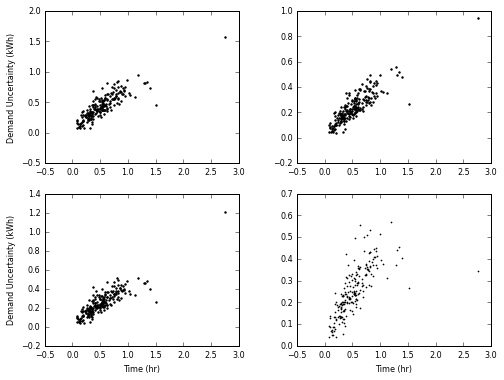

In [11]:
cusdemand = db1
cus_demand_list = np.mean(cusdemand, axis = 1)
y = np.array(ucmlist[:-1])
y3 = np.array(meanlist3[:-1])
y2 = np.array(meanlist2[:-1])
y1 = np.array(meanlist1[:-1])
x = cus_demand_list
print x.shape, y.shape

print 'customer characterization \n----print all customers - demand and uncertainty'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(hspace=.2, wspace=.3)
# first
ax = fig.add_subplot(2, 2, 1)
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)
ax.set_xmargin(0.02)
ax.set_ymargin(0.02)
ax.scatter(x, y, color='black', s = 2)
#ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')

# second
ax = fig.add_subplot(2, 2, 2)
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)
ax.set_xmargin(0.02)
ax.set_ymargin(0.02)
ax.scatter(x, y3, color='black', s = 2)
#ax.set_xlabel('Time (hr)')
#ax.set_ylabel('Demand Uncertainty (kWh)')

# third
ax = fig.add_subplot(2, 2, 3)
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)
ax.set_xmargin(0.02)
ax.set_ymargin(0.02)
ax.scatter(x, y2, color='black', s = 2)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')

# forth
ax = fig.add_subplot(2, 2, 4)
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)
ax.set_xmargin(0.02)
ax.set_ymargin(0.02)
ax.scatter(x, y1, color='black', s = 0.5)
ax.set_xlabel('Time (hr)')
#ax.set_ylabel('Demand Uncertainty (kWh)')

plt.show()
fig.savefig('scatterplot.png')

(200,) (200,)
Low Freq. Channel  
----print all customers - demand and low freq. channel uncertainty


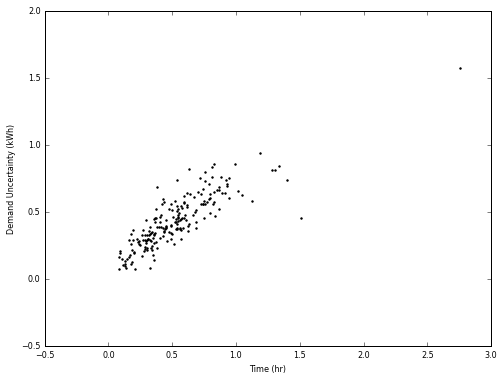

In [12]:
cusdemand = db1
cus_demand_list = np.mean(cusdemand, axis = 1)
y = np.array(ucmlist[:-1])
x = cus_demand_list
print x.shape, y.shape

print 'Low Freq. Channel  \n----print all customers - demand and low freq. channel uncertainty'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)


ax.scatter(x, y, color='black', s = 2)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()
fig.savefig('scatterplot.png')

(200, 10752)
ucm shape: (201,)
ucd shape: (201, 224)
uct shape: (201, 48)


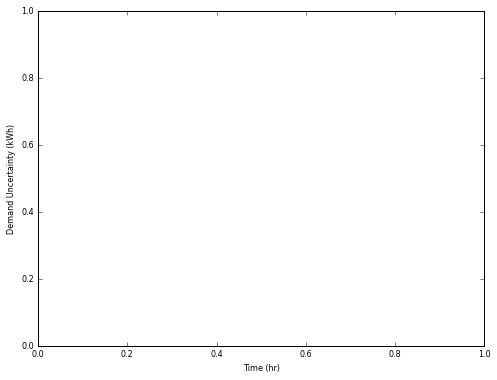

In [16]:
demand_hr = db1
print demand_hr.shape
uct = np.array(uctlist)
ucm = np.array(ucmlist)
ucd = np.array(ucdlist)
print 'ucm shape: ' + str(ucm.shape)
print 'ucd shape: ' + str(ucd.shape)
print 'uct shape: ' + str(uct.shape)
uc_mean_all = np.array(ucm)[:-1]
uc_mean_daily = np.array(ucd)[:-1]
uc_mean_timepoints = np.array(uct)[:-1]
d_1 = np.array(datelist1)[:-1]
d_2 = np.array(datelist2)[:-1]
d_3 = np.array(datelist3)[:-1]

uc_mean_weeks_tmp = uc_mean_daily.reshape([uc_mean_daily.shape[0], -1, 7])
w_1 = uc_mean_daily.reshape([d_1.shape[0], -1, 7])
w_2 = uc_mean_daily.reshape([d_2.shape[0], -1, 7])
w_3 = uc_mean_daily.reshape([d_3.shape[0], -1, 7])
#m_1 = uc_mean_daily.reshape([d_1.shape[0], -1, 15])
#m_2 = uc_mean_daily.reshape([d_2.shape[0], -1, 15])
#m_3 = uc_mean_daily.reshape([d_3.shape[0], -1, 15])

uc_mean_weeks = np.mean(uc_mean_weeks_tmp, axis = 1)
uc_mean_week = np.mean(uc_mean_weeks, axis = 0)
w1 = np.mean(w_1, axis = 1)
w1 = np.mean(w1, axis = 0)
w2 = np.mean(w_2, axis = 1)
w2 = np.mean(w2, axis = 0)
w3 = np.mean(w_3, axis = 1)
w3 = np.mean(w3, axis = 0)

plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

x = range(7)
#ax.plot(x, w1, color='r', ls='solid', linewidth = )
#ax.plot(x, w2, color='g', ls='solid', linewidth = 1)
#ax.plot(x, w3, color='b', ls='solid', linewidth = 1)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
#plt.show()
fig.savefig('load_profiles.png')

In [20]:
uc_mean_daily.shape

(200, 224)

Low Freq. Channel  
----print all customers - demand and low freq. channel uncertainty


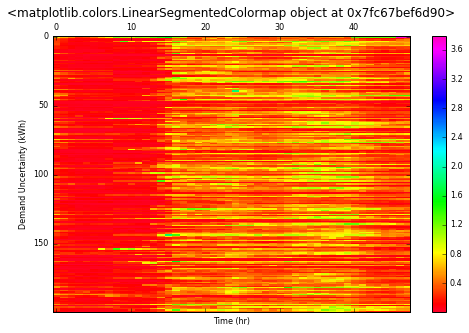

In [18]:
print 'Low Freq. Channel  \n----print all customers - demand and low freq. channel uncertainty'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 8/1.618))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

color = cm.gist_rainbow
im = ax.matshow(uc_mean_timepoints, cmap=color, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im)
plt.title(color)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()

Low Freq. Channel  
----print all customers - demand and low freq. channel uncertainty


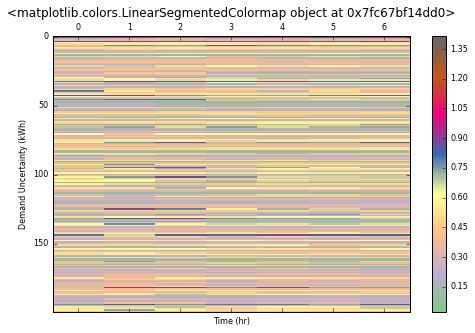

In [19]:
print 'Low Freq. Channel  \n----print all customers - demand and low freq. channel uncertainty'
plt.rc('font', family='serif')

fig = plt.figure(figsize=(8, 8/1.618))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('The x values')
ax.set_ylabel('The y values')
plt.rc('font', family = 'serif', serif = 'Times')
plt.rc('xtick', labelsize = 8)
plt.rc('ytick', labelsize = 8)
plt.rc('axes', labelsize = 8)

color = cm.Accent
im = ax.matshow(uc_mean_weeks, cmap=color, aspect='auto') # pl is pylab imported a pl
plt.colorbar(im)
plt.title(color)
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Demand Uncertainty (kWh)')
plt.show()

<function colormaps at 0x7fc6755c3e60>


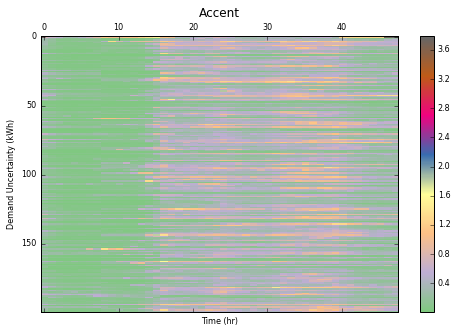

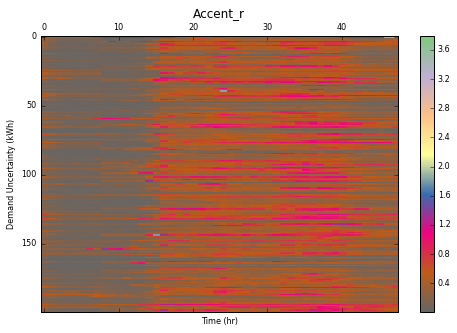

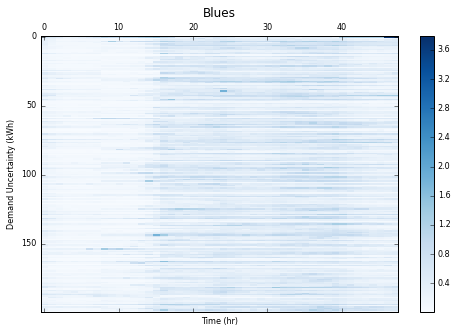

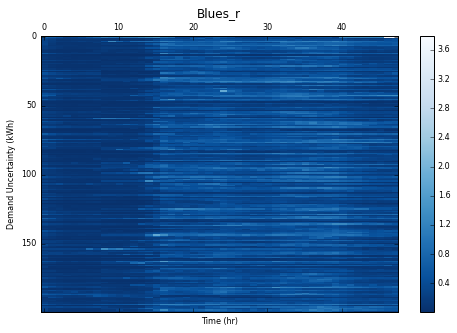

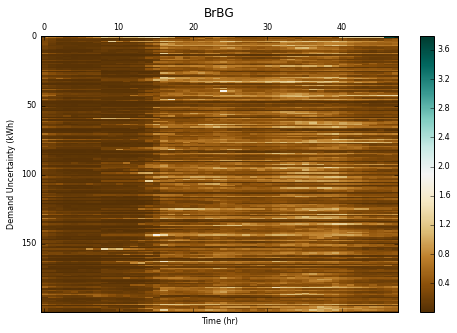

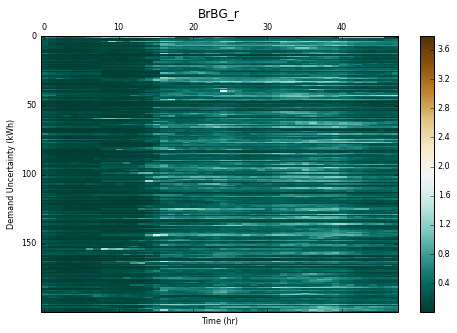

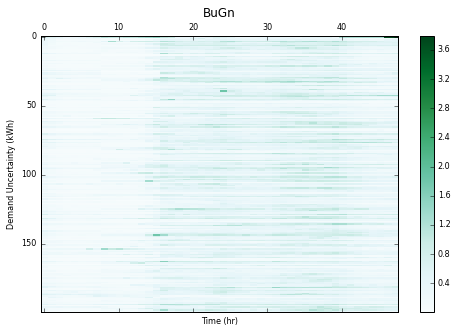

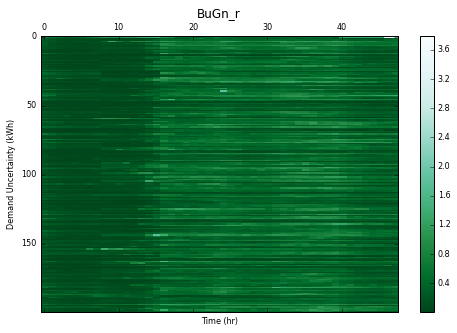

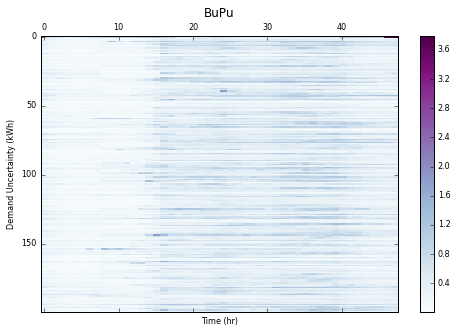

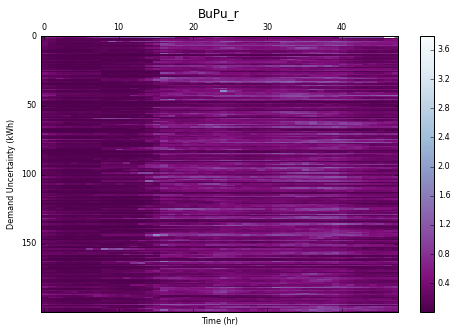

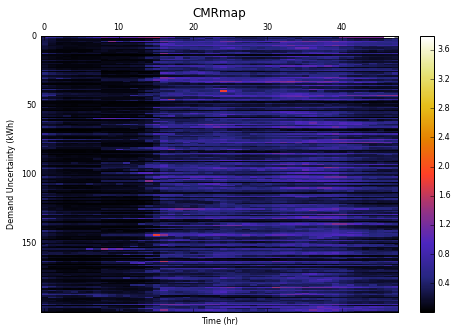

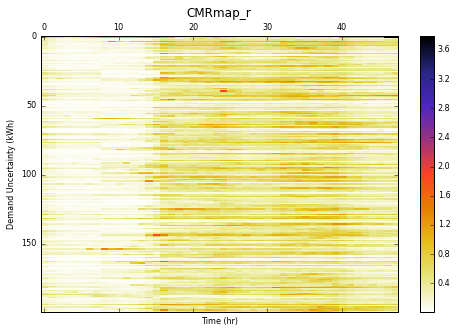

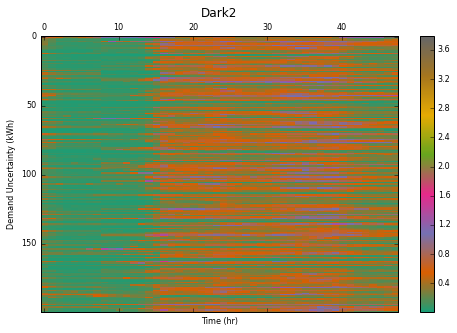

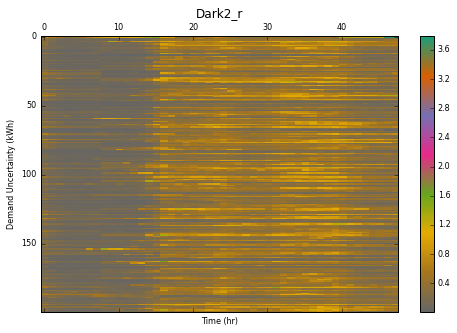

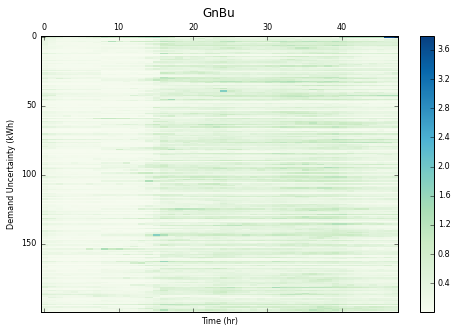

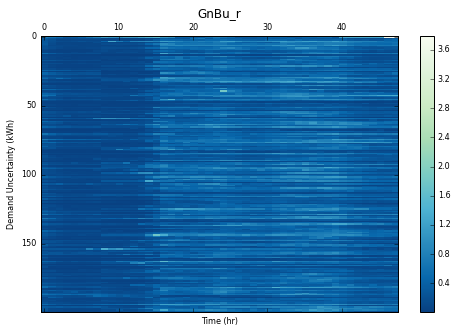

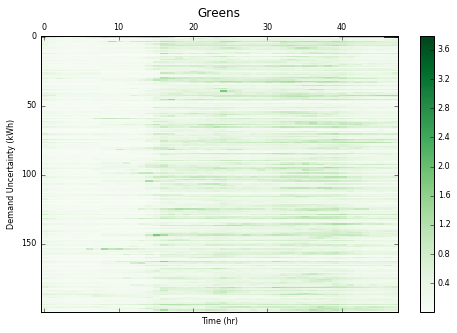

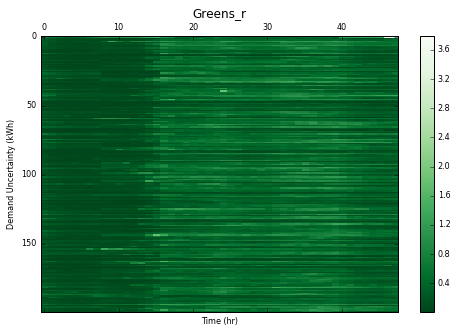

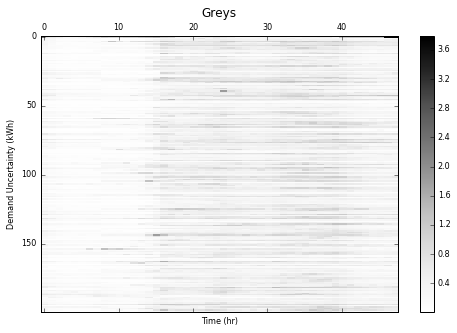

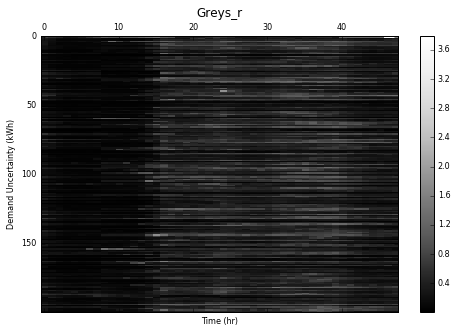

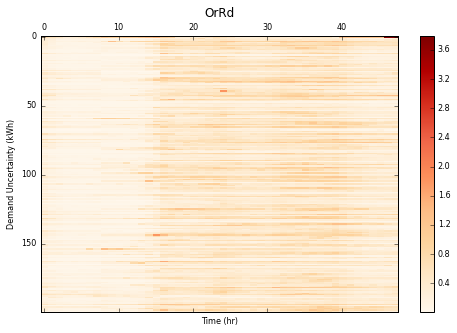

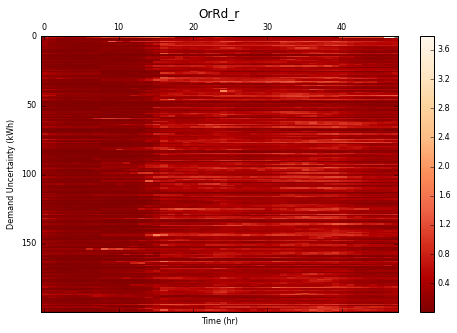

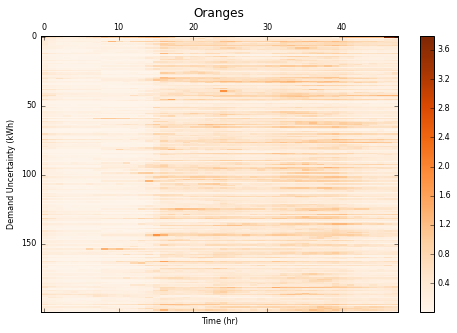

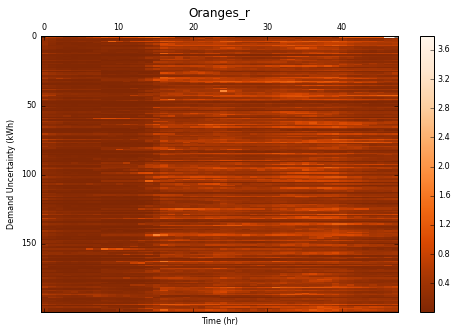

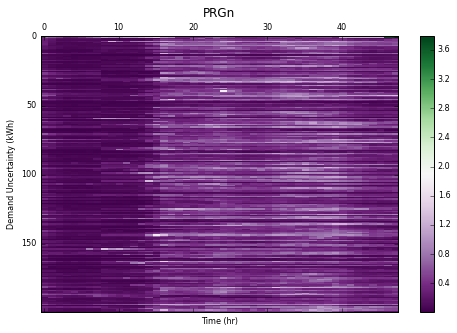

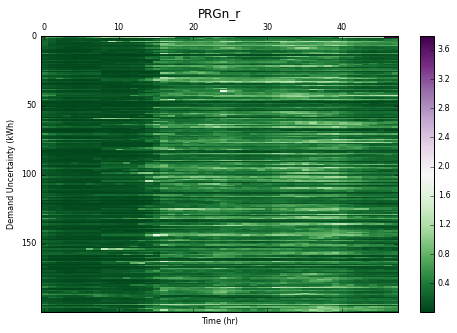

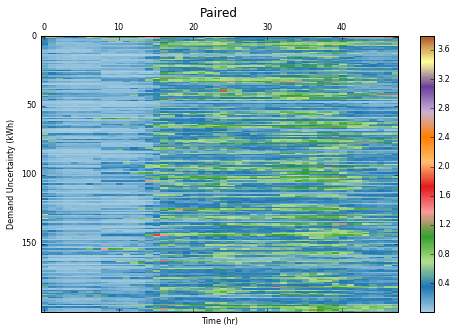

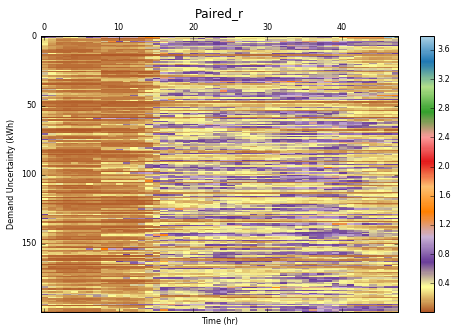

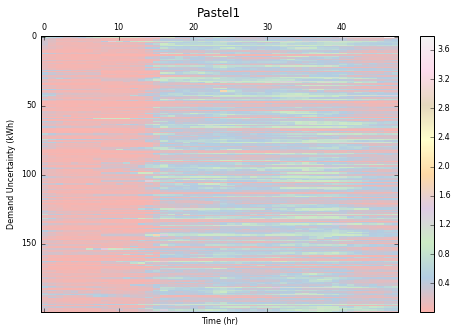

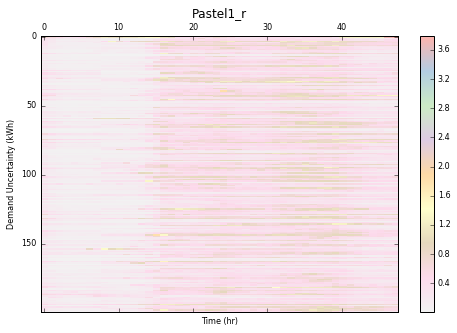

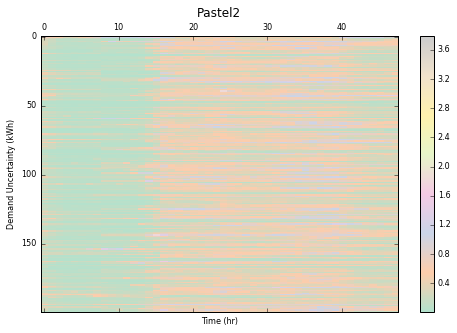

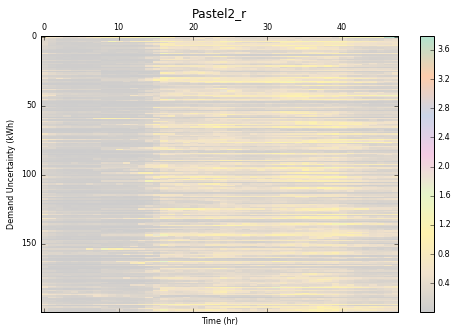

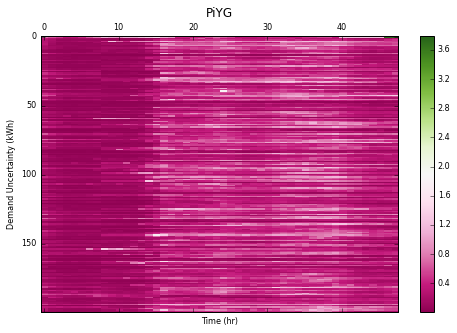

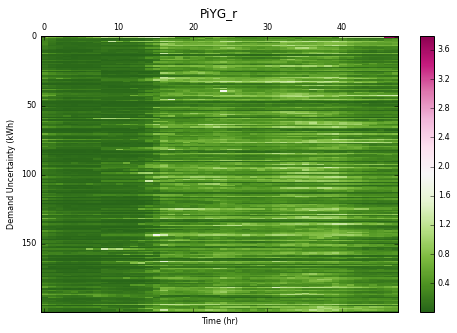

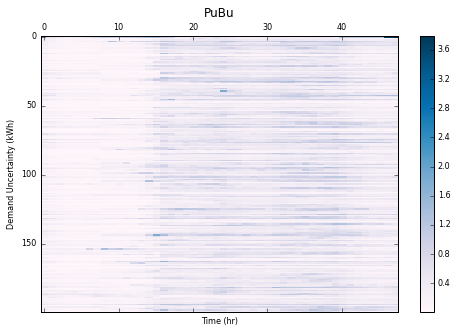

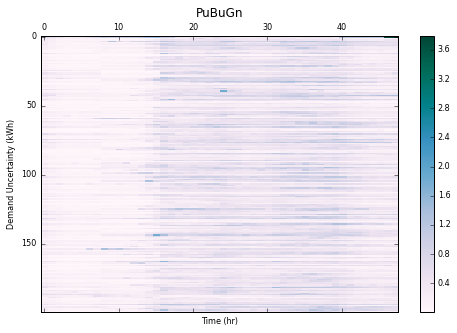

KeyboardInterrupt: 

In [21]:
print colormaps
for color in colormaps():
    plt.rc('font', family='serif')
    fig = plt.figure(figsize=(8, 8/1.618))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_xlabel('The x values')
    ax.set_ylabel('The y values')
    plt.rc('font', family = 'serif', serif = 'Times')
    plt.rc('xtick', labelsize = 8)
    plt.rc('ytick', labelsize = 8)
    plt.rc('axes', labelsize = 8)
    im = ax.matshow(uc_mean_timepoints, cmap = color, aspect='auto') # pl is pylab imported a pl
    plt.colorbar(im)
    plt.title(color)
    ax.set_xlabel('Time (hr)')
    ax.set_ylabel('Demand Uncertainty (kWh)')
    plt.show()